In [369]:
import numpy as np
import pandas as pd
import spacy
import networkx as nx
import score as sc
import time
from sklearn.metrics import confusion_matrix, pairwise, f1_score, precision_score
from scipy.spatial import distance
from preprocessing.utils import plot_confusion_matrix
import matplotlib.pyplot as plt
import nltk
from collections import Counter, defaultdict
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import itertools
import torch
import importlib
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC

In [370]:
import sys
importlib.reload(sys.modules['preprocessing.utils'])
from preprocessing.utils import plot_confusion_matrix

In [265]:
#https://github.com/huggingface/neuralcoref
#note: this NEEDS spacy 2.0.12 to work! downgrade with pip install spacy=2.0.12
import en_coref_md
nlp = spacy.load('en_core_web_sm')
coref = en_coref_md.load()

In [266]:
negating_words = set([
    "n't", "not", "no", 
    "never", "nobody", "non", "nope"])
doubting_words = set([
    'fake','fraud', 'hoax', 
    'false', 'deny', 'denies', 
    'despite', 'doubt', 
    'bogus', 'debunk', 'prank', 
    'retract', 'scam', "withdrawn",
    "misinformation"])
hedging_words = set([
    'allege', 'allegedly','apparently',
    'appear','claim','could',
    'evidently','largely','likely',
    'mainly','may', 'maybe', 'might',
    'mostly','perhaps','presumably',
    'probably','purport', 'purportedly',
    'reported', 'reportedly',
    'rumor', 'rumour', 'rumored', 'rumoured',
    'says','seem','somewhat',
    'unconfirmed'])
sus_words = doubting_words.union(hedging_words)

In [267]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
vader = SentimentIntensityAnalyzer()

def get_sentiment(sentence):
    sent =  vader.polarity_scores(sentence.text)
    return [sent["pos"],sent["neg"],sent["neu"],sent["compound"]]

def get_avg_sentiment(lst):
    sents = np.array([get_sentiment(s) for s in lst])
    return list(np.mean(sents, axis = 0))

def get_diff_sentiment(a,b):
    return list(np.absolute(np.array(a) - np.array(b)))

In [268]:
def train_test_split(bodies, stances, split=0.8):
    idx = np.random.permutation(np.arange(len(bodies)))
    bodies = bodies.values[idx]
    train = int(len(bodies)*0.8)
    bodies_tr = set([i[0] for i in bodies[:train]])
    bodies_val = set([i[0] for i in bodies[train:]])
    stances_tr = stances.loc[stances["Body ID"].isin(bodies_tr), :]
    stances_val = stances.loc[stances["Body ID"].isin(bodies_val), :]
    return stances_tr, stances_val

In [269]:
train_stances = pd.read_csv("fn_data/train_stances.csv")
train_stances = train_stances.loc[lambda x: x.Stance != "unrelated"]
print(train_stances.shape)
train_stances.head(15)

(13427, 3)


,Headline,Body ID,Stance
1,Hundreds of Palestinians flee floods in Gaza a...,158,agree
4,Spider burrowed through tourist's stomach and ...,1923,disagree
5,'Nasa Confirms Earth Will Experience 6 Days of...,154,agree
8,Banksy 'Arrested & Real Identity Revealed' Is ...,1739,agree
10,Gateway Pundit,2327,discuss
11,Woman detained in Lebanon is not al-Baghdadi's...,1468,agree
14,"Soon Marijuana May Lead to Ticket, Not Arrest,...",47,discuss
16,Boko Haram Denies Nigeria Cease-Fire Claim,2463,discuss
17,"No, Robert Plant Didn’t Rip Up an $800 Million...",295,agree
19,ISIL Beheads American Photojournalist in Iraq,608,discuss


In [270]:
train_bodies = pd.read_csv("fn_data/train_bodies.csv")
print(train_bodies.shape)
train_bodies.head()

(1683, 2)


,Body ID,articleBody
0,0,A small meteorite crashed into a wooded area i...
1,4,Last week we hinted at what was to come as Ebo...
2,5,(NEWSER) – Wonder how long a Quarter Pounder w...
3,6,"Posting photos of a gun-toting child online, I..."
4,7,At least 25 suspected Boko Haram insurgents we...


((10964, 3), (2463, 3))

In [272]:
disagrees = stances_tr[stances_tr["Stance"]=="disagree"]
agrees = stances_tr[stances_tr["Stance"]=="agree"]
discusses = stances_tr[stances_tr["Stance"]=="discuss"]
stances_tr_augmented = pd.concat([stances_tr, agrees, disagrees, disagrees, disagrees, disagrees, disagrees, disagrees]).sample(frac=1).reset_index(drop=True)

In [273]:
def get_body(n):
    return train_bodies.loc[lambda x: x["Body ID"] == n, "articleBody"].item()

In [274]:
def preprocess(text):
    text = text.replace("' ",' ')
    text = text.replace(" '",' ')
    text = text.replace(":", ". ")
    text = text.replace(";", ". ")
    return text

In [275]:
def cosine_similarity(x,y):
    return 1 - np.nan_to_num(distance.cosine(x,y))

In [276]:
def get_topics(doc):
    """
    get topics of a sentence
    input: spacy doc
    output: dictionary with nouns as the key, and the set of noun chunks that contain the noun as the value
    special entry _vocab has the set of all tokens in the dict
    """
    subjs = {}
    for token in doc:
        if token.dep_ in ["nsubj", "nsubjpass", "csubj","csubjpass", "dobj", "dative", "attr", "oprd", "pobj", "compound"]:
            txt = token.lemma_.lower()
            if txt not in subjs:
                subjs[txt] = set([txt])      
    for chunk in doc.noun_chunks:
        if len(chunk.root.text) > 2:
            txt = chunk.root.text.lower()
            if txt not in subjs:
                subjs[txt] = set([txt])
            subjs[txt].add(chunk.text.lower())
    subjects_= []
    for word in subjs:
        for phrase in subjs[word]:
            subjects_ += phrase.split(" ")
    subjs["_vocab"] = set(subjects_)
    return subjs

In [277]:
def get_svos(sent):
    """
    input: Spacy processed sentence
    output: dict of subj, dict of v, dict of obj (each word is lemmatized and lowercased)
    each entry in dict has key of lemmatized token, value is actual token (to do traversals with later if needed)
    """
    s = {}
    v = {}
    o = {}
    for token in sent:
        if token.dep_ == 'ROOT':
            v[token.lemma_.lower()] = token
        elif token.dep_ in ["nsubj", "nsubjpass", "csubj","csubjpass", "agent","compound"]:
            s[token.lemma_.lower()] = token
        elif token.dep_ in ["dobj", "dative", "attr", "oprd", "pobj"]:
            o[token.lemma_.lower()] = token
    # https://github.com/clir/clearnlp-guidelines/blob/master/md/specifications/dependency_labels.md
    return (s,v,o)

In [278]:
def build_graph(doc):
    """
    build a NetworkX graph of the dependency tree
    input: spacy Doc
    output: networkx graph
    """
    edges = set()
    for token in doc:
        for child in token.children:
            edges.add((token.lemma_.lower(),child.lemma_.lower()))
    graph = nx.DiGraph(list(edges))
    return graph

In [279]:
def get_summary(doc, subjects, n = 5):
    """
    get summary of n sentences in document
    first meaningful sentence will always be returned
    """
    subjects_ = subjects["_vocab"]
    def score_sentence(sent):
        # not very robust right now
        score = 0
        word_count = 0
        for token in sent:
            word_count += 1
            t = token.lemma_.lower()
            if t in subjects_:
                score += 1
            elif t in negating_words or t in doubting_words or t in hedging_words:
                score += 0.5
            return score/word_count if word_count > 4 else 0
    sentences = [s for s in doc.sents]
    scored_sentences = [[idx, sent, score_sentence(sent)] for idx, sent in enumerate(sentences)]
    # scored_sentences = [s for s in scored_sentences if s[2] > 0] #filter out non-scoring sentences
    scored_sentences.sort(key = lambda x: x[2], reverse = True)
    top = scored_sentences[:n-1]
    top.sort(key = lambda x: x[0])
    result = [scored_sentences[0][1]] + [s[1] for s in top]
    return result

In [280]:
def get_shortest_path_to_negating(graph, subjects):
    """
    get the shortest path from each subject to any negating or doubting/hedging word
    returns: dictionary with subject as key, and 2-element list of path lengths [negating, doubting]
    - if a subject does not exist in graph or have a path to any negating word, then the value will be [None, None]
    """
    results = {}
    for s in subjects:
        results[s] = [None, None]
        if graph.has_node(s):
            for word in negating_words:
                if word in graph:
                    try:
                        path = nx.shortest_path(graph, source = s, target = word)
                        if results[s][0] == None or len(path) < results[s][0]:
                            results[s][0] = len(path)
                    except:
                        continue
            for word in sus_words:
                if word in graph:
                    try:
                        path = nx.shortest_path(graph, source = s, target = word)
                        if results[s][1] == None or len(path) < results[s][1]:
                            results[s][1] = len(path)
                    except:
                        continue
    return results

In [281]:
def root_distance(graph, root):
    """
    as implemented in the Emergent paper - return the shortest distance between the given root and any 
    doubting or hedging words in the graph, or None if no such path exists
    """
    if root == None:
        return None
    min_dist = None
    for word in sus_words:
        if word in graph:
            try:
                path = nx.shortest_path(graph, source = root, target = word)
                if min_dist == None or len(path) < min_dist:
                    min_dist = len(path)
            except:
                continue
    return min_dist

In [282]:
def get_neg_ancestors(doc):
    """
    get the ancestors of every negating word
    input: spacy Doc
    returns: tuple  - set of words that were in the ancestor list of negating words, 
    set of words that were in ancestor list of refuting words, # negating words, # refuting words
    """
    results = [set(), set(), 0, 0]
    for token in doc:
        if token.lemma_.lower() in negating_words:
            results[0] = results[0].union(
                set([ancestor.lemma_.lower() for ancestor in token.ancestors if len(ancestor) > 2])
            )
            results[2] += 1
        elif token.lemma_.lower() in sus_words:
            results[1] = results[1].union(
                set([ancestor.lemma_.lower() for ancestor in token.ancestors if len(ancestor) > 2])
            )
            results[3] += 1
    return tuple(results)

In [283]:
h_id = 20
df = agrees
test = nlp(preprocess(list(df.values)[h_id][0]))
print(test)
test_graph = build_graph(test)
test_subj = get_topics(test)
test_svo = get_svos(test)
print(get_shortest_path_to_negating(test_graph, test_subj))
print(test_subj, test_svo, list(test_svo[1].keys())[0])
print(root_distance(test_graph, list(test_svo[1].keys())[0]))
print(get_neg_ancestors(test))

Bugatti Veyron Vandalized With Penis Graffiti? Viral Photo Isn’t What It Seems
{'bugatti': [None, None], 'veyron': [None, None], 'penis': [None, None], 'graffiti': [None, None], 'viral': [None, None], 'photo': [None, None], 'what': [None, None], '-pron-': [None, None], '_vocab': [None, None]}
{'bugatti': {'bugatti'}, 'veyron': {'bugatti veyron', 'veyron'}, 'penis': {'penis'}, 'graffiti': {'penis graffiti', 'graffiti'}, 'viral': {'viral'}, 'photo': {'viral photo', 'photo'}, 'what': {'what'}, '-pron-': {'-pron-'}, '_vocab': {'what', 'bugatti', 'veyron', '-pron-', 'graffiti', 'penis', 'viral', 'photo'}} ({'bugatti': Bugatti, 'veyron': Veyron, 'penis': Penis, 'viral': Viral, 'photo': Photo, '-pron-': It}, {'vandalized': Vandalized, 'be': Is}, {'graffiti': Graffiti, 'what': What}) vandalized
None
(set(), set(), 1, 1)


In [284]:
body_text = get_body(list(df.values)[h_id][1])
body = coref(preprocess(body_text))
resolved = body._.coref_resolved
print(resolved)
print("")
body = nlp(resolved)
body_graph = build_graph(body)
summary = get_summary(body, test_subj, 5)
print(summary)
for s in summary:
    svo_s = get_svos(s)
    print(get_shortest_path_to_negating(body_graph, test_subj))
    print(svo_s)
    print(root_distance(body_graph, list(svo_s[1].keys())[0]))
    print(get_neg_ancestors(s))
    print("")

An image of a gold Bugatti Veyron graffitied with a drawing of a penis may have upset car lovers - but An image of a gold Bugatti Veyron graffitied with a drawing of a penis turns out the vehicle was included in a YouTube hoax.

Photos from multiple Instagram accounts have revealed the vehicle wasn't permanently damaged.

Instagram user @andreysmygov uploaded a photo last Friday of the Veyron with a caption that suggested it was painted on as a stunt for TwinzTV, Car Crushing noted.

Scroll down for video

Graffitied.  A photo of the Veyron the Veyron was reportedly taken in Seattle, according to a Reddit post

Busted.  A photo of the vandalised Bugatti Veyron included a caption suggesting the car was spray-painted as a stunt with TwinzTV

'How often do u get to spray paint on a Bugatti lol shoutout to the homie @vgtorious for letting us @twinztv1 @twinztv2 @twinz_tv @nigxl @alexwood66, @alexwood66 wrote online.

Brothers Jeremy and Jason Holden run the YouTube pranks channel TwinzTV.


In [285]:
headline_info = {}
body_info = {}
start = time.time()
stance_data = list(train_stances.values)
body_data = list(train_bodies.values)
for headline in range(len(stance_data)):
    if headline % 2500 == 0:
        print("Processed "+str(headline))
    h, b_id, s = tuple(stance_data[headline])
    nlp_h = nlp(preprocess(h))
    headline_graph = build_graph(nlp_h)
    headline_subj = get_topics(nlp_h)
    headline_svo = get_svos(nlp_h)
    headline_root_dist = root_distance(headline_graph, list(headline_svo[1].keys())[0])
    headline_neg_ancestors = get_neg_ancestors(nlp_h)
    nqh = 0
    for tok in nlp_h:
        if tok.text == "?":
            nqh += 1
    headline_info[h] = (nlp_h, headline_graph, headline_subj, headline_svo, headline_root_dist, headline_neg_ancestors, nqh)
print("Done!")
for body in range(len(body_data)):
    if body % 100 == 0:
        print("Processed "+str(body))
    b_id, txt = tuple(body_data[body])
    nlp_a = coref(preprocess(txt))
    nlp_b = nlp(nlp_a._.coref_resolved)
    body_graph = build_graph(nlp_b)
    nqb = 0
    for tok in nlp_b:
        if tok.text == "?":
            nqb += 1
    body_info[b_id] = (nlp_b, body_graph, nqb)
print("Done!")
end = time.time()
print(int(end-start))

Processed 0
Processed 2500
Processed 5000
Processed 7500
Processed 10000
Processed 12500
Done!
Processed 0
Processed 100
Processed 200
Processed 300
Processed 400
Processed 500
Processed 600
Processed 700
Processed 800
Processed 900
Processed 1000
Processed 1100
Processed 1200
Processed 1300
Processed 1400
Processed 1500
Processed 1600
Done!
878


In [286]:
def get_sentence_vec(s):
    vecs = [token.vector for token in s]
    return np.nan_to_num(np.sum(vecs, axis = 0))

def get_features(stance_df, n_sent = 5):
    start = time.time()
    data = list(stance_df.values)
    features = []
    actual = []
    for item in data:
        h, b, s = tuple(item)
        headline, headline_graph, headline_subjs, headline_svo, headline_root_dist, headline_neg_ancestors, nq_h  = headline_info[h]
        body, body_graph, nq_b = body_info[b]
        
        #sometimes the coref deletes bodies that are one sentence
        if len(body) == 0:
            body = nlp(preprocess(get_body(b)))
            body_graph = build_graph(body)

        #return the shortest path to negating word for each subject in headline_subjs, if one exists
        neg_h = get_shortest_path_to_negating(headline_graph, headline_subjs)
        neg_b = get_shortest_path_to_negating(body_graph, headline_subjs)

        #body summary
        summary = get_summary(body, headline_subjs, n_sent)
        first_summ_sentence = summary[0]
        
        summary_svos = [get_svos(s) for s in summary]
        summary_root_dist = [root_distance(body_graph, list(s[1].keys())[0]) for s in summary_svos]
        summary_neg_ancestors = [get_neg_ancestors(s) for s in summary]
        summary_neg_counts = [s[2:] for s in summary_neg_ancestors]
        
        #svo
        body_s, body_v, body_o = {}, {}, {}
        headline_s, headline_v, headline_o = headline_svo
        for svo in summary_svos:
            body_s.update(svo[0])
            body_v.update(svo[1])
            body_o.update(svo[2])
        body_s_vec = list(np.sum([body_s[s].vector for s in body_s], axis = 0)) if len(body_s) > 0 else np.zeros(384)
        body_v_vec = list(np.sum([body_v[s].vector for s in body_v], axis = 0)) if len(body_v) > 0 else np.zeros(384)
        body_o_vec = list(np.sum([body_o[s].vector for s in body_o], axis = 0)) if len(body_o) > 0 else np.zeros(384)
    
        headline_s_vec = list(np.sum([headline_s[s].vector for s in headline_s], axis = 0)) if len(headline_s) > 0 else np.zeros(384)
        headline_v_vec = list(np.sum([headline_v[s].vector for s in headline_v], axis = 0)) if len(headline_v) > 0 else np.zeros(384)
        headline_o_vec = list(np.sum([headline_o[s].vector for s in headline_o], axis = 0)) if len(headline_o) > 0 else np.zeros(384)
        
        cos_sim_s = cosine_similarity(body_s_vec, headline_s_vec)
        cos_sim_v = cosine_similarity(body_v_vec, headline_v_vec)
        cos_sim_o = cosine_similarity(body_o_vec, headline_o_vec)
        
        #negating paths
        headline_paths = [neg_h[x] for x in neg_h]
        headline_neg_paths = [1 if x[0] != None else 0 for x in headline_paths] + [1]
        headline_hedge_paths = [1 if x[1] != None else 0 for x in headline_paths] + [1]
        body_paths = [neg_h[x] for x in neg_h]
        body_neg_paths = [1 if x[0] != None else 0 for x in body_paths] + [1]
        body_hedge_paths = [1 if x[1] != None else 0 for x in body_paths] + [1]
        
        neg_path_cos_sim = cosine_similarity(headline_neg_paths, body_neg_paths)
        hedge_path_cos_sim = cosine_similarity(headline_hedge_paths, body_hedge_paths)
        
        #root distance
        avg_summary_root_dist = None
        non_null = [x for x in summary_root_dist if x != None]
        if len(non_null) != 0:
            avg_summary_root_dist = sum(non_null)/len(non_null)
        root_dist_feats = [headline_root_dist, avg_summary_root_dist]
        root_dist_feats = [x if x != None else 100 for x in root_dist_feats]
    
        #sentiment
        headline_sent = get_sentiment(headline)
        body_sents = [get_sentiment(s) for s in summary]
        diff_sents = list(np.sum([get_diff_sentiment(headline_sent, s) for s in body_sents], axis = 0))
        
        #bow
        headline_vocab = set([tok.lemma_.lower() for tok in headline])
        fst_summ_vocab = set([tok.lemma_.lower() for tok in first_summ_sentence])
        total_vocab = list(headline_vocab.union(fst_summ_vocab))
        headline_embedding = [1 if tok in headline_vocab else 0 for tok in total_vocab]
        fst_summ_embedding = [1 if tok in fst_summ_vocab else 0 for tok in total_vocab]
        bow_cos_sim = cosine_similarity(headline_embedding, fst_summ_embedding)
        
        #word vecs
        cos_sims = [cosine_similarity(get_sentence_vec(s), headline.vector) for s in summary]
        fst_cos_sim = cos_sims[0]
        avg_cos_sim = sum(cos_sims)/len(cos_sims)
        
        #build final features list
        fts = (
            [fst_cos_sim, avg_cos_sim, bow_cos_sim, 
               neg_path_cos_sim, hedge_path_cos_sim, 
               cos_sim_s, cos_sim_v, cos_sim_o, nq_h, nq_b] + 
            headline_sent + diff_sents + root_dist_feats + 
            list(headline_neg_ancestors[2:]) + list(np.sum(summary_neg_counts, axis = 0))
        )
        features.append(fts)
        actual.append(s)
    end = time.time()
    print(int(end-start))
    return features, actual

In [382]:
stance_data = get_features(train_stances, 5)
stance_dict = {}
for idx, d in enumerate(list(train_stances.values)):
    h, b, s = d
    stance_dict[(h, b)] = stance_data[0][idx]

/Users/dannyyang/Library/Python/3.6/lib/python/site-packages/scipy/spatial/distance.py:505: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - np.dot(u, v) / (norm(u) * norm(v))


81


In [418]:
def train_multiple(models, folds = 1, sampling = [1,1,1]):
    """
    helper function for training on multiple splits
    this isn't true K-fold CV because of the way we do our splits and augmentation
    models: a list of instantiated models
    folds: number of splits
    sampling: list of 3 ints, representing how much we should oversample agree, disagree, discuss
            for example, [1,1,2] will sample each discuss item twice
    """
    for i in range(folds):
        print("Training Fold "+str(i + 1))
        stances_tr, stances_val = train_test_split(train_bodies, train_stances)
        disagrees = stances_tr[stances_tr["Stance"]=="disagree"]
        agrees = stances_tr[stances_tr["Stance"]=="agree"]
        discusses = stances_tr[stances_tr["Stance"]=="discuss"]
        data = []
        for i in range(sampling[0]):
            data.append(agrees)
        for i in range(sampling[1]):
            data.append(disagrees)
        for i in range(sampling[2]):
            data.append(discusses)
        stances_tr_augmented = pd.concat(data).sample(frac=1).reset_index(drop=True)
        training_data = [[],[]]
        for h,b,s in list(stances_tr_augmented.values):
            training_data[0].append(stance_dict[(h,b)])
            training_data[1].append(s)
        testing_data = [[],[]]
        for h,b,s in list(stances_val.values):
            testing_data[0].append(stance_dict[(h,b)])
            testing_data[1].append(s)
        c1, c2 = Counter(training_data[1]), Counter(testing_data[1])
        baseline_tr = c1['discuss']/(c1['agree']+c1['disagree']+c1['discuss'])
        baseline_val = c2['discuss']/(c2['agree']+c2['disagree']+c2['discuss'])
        print("Training Baseline {0:.2f}% Testing Baseline {1:.2f}%".format(baseline_tr * 100, baseline_val * 100))
        for m in range(len(models)):
            model = models[m]
            print("Model "+str(m + 1))
            model.fit(training_data[0], training_data[1])
            tr_acc = model.score(training_data[0], training_data[1])
            print('{0:.2f}% training accuracy, vs Baseline {1:.2f}%'.format(tr_acc*100, (tr_acc-baseline_tr)*100))
            val_acc = model.score(testing_data[0], testing_data[1])
            print('{0:.2f}% validation accuracy, vs Baseline {1:.2f}%'.format(val_acc*100, (val_acc-baseline_val)*100))
        print("#"*50)
    return models

In [521]:
sampling = [1,1,1]
stances_tr, stances_val = train_test_split(train_bodies, train_stances)
disagrees = stances_tr[stances_tr["Stance"]=="disagree"]
agrees = stances_tr[stances_tr["Stance"]=="agree"]
discusses = stances_tr[stances_tr["Stance"]=="discuss"]
data = []
for i in range(sampling[0]):
    data.append(agrees)
for i in range(sampling[1]):
    data.append(disagrees)
for i in range(sampling[2]):
    data.append(discusses)
stances_tr_augmented = pd.concat(data).sample(frac=1).reset_index(drop=True)
training_data = [[],[]]
for h,b,s in list(stances_tr_augmented.values):
    training_data[0].append(stance_dict[(h,b)])
    training_data[1].append(s)
testing_data = [[],[]]
for h,b,s in list(stances_val.values):
    testing_data[0].append(stance_dict[(h,b)])
    testing_data[1].append(s)
c1, c2 = Counter(training_data[1]), Counter(testing_data[1])
baseline_tr = c1['discuss']/(c1['agree']+c1['disagree']+c1['discuss'])
baseline_val = c2['discuss']/(c2['agree']+c2['disagree']+c2['discuss'])
print(c1, c2)
print("Training Baseline {0:.2f}% Testing Baseline {1:.2f}%".format(baseline_tr * 100, baseline_val * 100))

Counter({'discuss': 7172, 'agree': 2925, 'disagree': 650}) Counter({'discuss': 1737, 'agree': 753, 'disagree': 190})
Training Baseline 66.73% Testing Baseline 64.81%


In [406]:
# for i in range(30):
#     print(np.size(training_data[0][i][0]))
# for i in range(len(training_data[0][0])):
#     r = []
#     for row in training_data[0]:
#         r.append(row[i])
#     print(r[:25])

In [476]:
def label_to_int(labels):
    return [(1 if l == "agree" else (0 if l == "discuss" else -1)) for l in labels]

# SIMPLE MODELS

In [500]:
models1 = [
GradientBoostingClassifier(n_estimators = 400, subsample = 0.2, learning_rate = 0.025, random_state=0, min_samples_leaf = 3),
]
models2 = [
GradientBoostingClassifier(n_estimators = 400, subsample = 0.2, learning_rate = 0.025, random_state=0, min_samples_leaf = 3),
]
models3 = [
GradientBoostingClassifier(n_estimators = 400, subsample = 0.2, learning_rate = 0.025, random_state=0, min_samples_leaf = 3),
]
models4 = [
GradientBoostingClassifier(n_estimators = 400, subsample = 0.2, learning_rate = 0.025, random_state=0, min_samples_leaf = 3),
]
trained1 = train_multiple(models1, 1, [0,8,1])
trained2 = train_multiple(models2, 1, [2,0,1])
trained3 = train_multiple(models3, 1, [2,8,0])
trained4 = train_multiple(models3, 1, [1,1,1])

Training Fold 1
Training Baseline 56.82% Testing Baseline 65.89%
Model 1
85.45% training accuracy, vs Baseline 28.63%
58.96% validation accuracy, vs Baseline -6.93%
##################################################
Training Fold 1
Training Baseline 55.34% Testing Baseline 63.15%
Model 1
76.19% training accuracy, vs Baseline 20.85%
67.17% validation accuracy, vs Baseline 4.03%
##################################################
Training Fold 1
Training Baseline 0.00% Testing Baseline 68.31%
Model 1
85.11% training accuracy, vs Baseline 85.11%
23.29% validation accuracy, vs Baseline -45.02%
##################################################
Training Fold 1
Training Baseline 66.99% Testing Baseline 63.79%
Model 1
75.86% training accuracy, vs Baseline 8.87%
69.12% validation accuracy, vs Baseline 5.33%
##################################################


In [528]:
# model = RandomForestClassifier(max_depth = 8, n_estimators=250, random_state = 0, min_samples_split = 10, min_samples_leaf = 5)
model = LogisticRegression(max_iter = 200)
models = [trained1[0], trained2[0], trained3[0], trained4[0]]
preds = [label_to_int(m.predict(training_data[0])) for m in models]
# model = SVC()
# model = GradientBoostingClassifier(n_estimators = 500, subsample = 0.1, learning_rate = 0.02, random_state=0)
model.fit(np.swapaxes(preds,0,1), training_data[1])
tr_acc = model.score(tr_input, training_data[1])
print('{0:.2f}% training accuracy'.format(tr_acc*100))

test_preds = [label_to_int(m.predict(testing_data[0])) for m in models]
val_acc = model.score(np.swapaxes(test_preds,0,1), testing_data[1])
print('{0:.2f}% validation accuracy'.format(val_acc*100))
print("Baseline comparison: {0:.2f}%".format((val_acc-baseline_val)*100))

74.57% training accuracy
70.30% validation accuracy
Baseline comparison: 5.49%


In [415]:
# print(model.classes_, model.coef_)

-------------------------------------------------------------
|           |   agree   | disagree  |  discuss  | unrelated |
-------------------------------------------------------------
|   agree   |    274    |     0     |    479    |     0     |
-------------------------------------------------------------
| disagree  |    39     |     6     |    145    |     0     |
-------------------------------------------------------------
|  discuss  |    132    |     1     |   1604    |     0     |
-------------------------------------------------------------
| unrelated |     0     |     0     |     0     |   7500    |
-------------------------------------------------------------
Score: 3958.0 out of 4555.0	(86.89352360043908%)
F1 Score
[0.45742905 0.06091371 0.80907945 1.        ]
Avg Precision Score
[0.61573034 0.85714286 0.71992819 1.        ]
Normalized confusion matrix
[[3.63877822e-01 0.00000000e+00 6.36122178e-01 0.00000000e+00]
 [2.05263158e-01 3.15789474e-02 7.63157895e-01 0.00000000

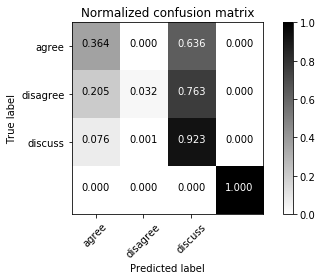

In [529]:
actual = testing_data[1]
predicted = model.predict(np.swapaxes(test_preds,0,1))
actual = actual + ["unrelated"] * 7500
predicted = np.concatenate((predicted, ["unrelated"] * 7500),axis = 0)
sc.report_score(actual, predicted)
print("F1 Score")
print(f1_score(actual, predicted, average = None))
print("Avg Precision Score")
print(precision_score(actual, predicted, average = None))
matrix = confusion_matrix(actual,predicted)
plot_confusion_matrix(matrix, classes=["agree","disagree", "discuss"],
                      title='Normalized confusion matrix')
plt.show()